# Pathway Analysis, Enrichr - gget enrichr

In [ ]:
# try:
#     import varseek as vk
# except ImportError:
#     print("varseek not found, installing...")
#     !pip install -U -q varseek
# try:
#     import RLSRWP_2025
# except ImportError:
#     print("RLSRWP_2025 not found, installing...")
#     !pip install -q git+https://github.com/pachterlab/RLSRWP_2025.git
# try:
#     import gget
# except ImportError:
#     print("gget not found, installing...")
#     !pip install -U -q gget

In [1]:
import gget
import pandas as pd
import os
import shutil
import subprocess
import anndata as ad

from varseek.utils import convert_mutation_cds_locations_to_cdna

RLSRWP_2025_dir = os.path.dirname(os.path.abspath(""))  # if this notebook resides in RLSRWP_2025/notebooks/0_data_download.ipynb, then this retrieves RLSRWP_2025

In [2]:
n = 500
sorting_column = "vcrs_count"  # "vcrs_count" (sort by variant), "gene_count" (sort by gene), etc
databases = ['pathway', 'transcription', 'ontology', 'diseases_drugs', 'celltypes', 'kinase_interactions']

vk_count_out_dir = os.path.join(RLSRWP_2025_dir, "data", "vk_count_out")
adata_path = os.path.join(vk_count_out_dir, "adata_cleaned.h5ad")

out_dir = os.path.join(vk_count_out_dir, "analysis", "gget_enrichr")

reference_dir = os.path.join(RLSRWP_2025_dir, "data", "reference")
cosmic_csv = os.path.join(reference_dir, "cosmic", "CancerMutationCensus_AllData_Tsv_v101_GRCh37", "CancerMutationCensus_AllData_v101_GRCh37_mutation_workflow.csv")
sequences_cds = os.path.join(reference_dir, "ensembl_grch37_release93", "Homo_sapiens.GRCh37.cds.all.fa")
sequences_cdna = os.path.join(reference_dir, "ensembl_grch37_release93", "Homo_sapiens.GRCh37.cdna.all.fa")

In [3]:
os.makedirs(out_dir, exist_ok=True)
adata = ad.read_h5ad(adata_path)

adata.var.head()

,vcrs_header,vcrs_count
variant,,
ENST00000391429:c.194C>T,ENST00000391429:c.194C>T,0.0
ENST00000391429:c.128C>A,ENST00000391429:c.128C>A,0.0
ENST00000391429:c.257C>A,ENST00000391429:c.257C>A,0.0
ENST00000391429:c.100G>A,ENST00000391429:c.100G>A,0.0
ENST00000391429:c.99G>A,ENST00000391429:c.99G>A,0.0


In [11]:
adata_var_columns = adata.var.columns

# download cosmic and cdna
if not os.path.exists(sequences_cdna):
    print("Downloading cDNA")
    reference_cdna_dir = os.path.dirname(sequences_cdna) if os.path.dirname(sequences_cdna) else "."
    gget_ref_command = ["gget", "ref", "-w", "cdna", "-r", "93", "--out_dir", reference_cdna_dir, "-d", "human_grch37"]
    subprocess.run(gget_ref_command, check=True)
    subprocess.run(["gunzip", f"{sequences_cdna}.gz"], check=True)
if not os.path.exists(sequences_cds):
    print("Downloading CDS")
    reference_cds_dir = os.path.dirname(sequences_cds) if os.path.dirname(sequences_cds) else "."
    gget_ref_command = ["gget", "ref", "-w", "cds", "-r", "93", "--out_dir", reference_cds_dir, "-d", "human_grch37"]
    subprocess.run(gget_ref_command, check=True)
    subprocess.run(["gunzip", f"{sequences_cds}.gz"], check=True)

if not os.path.exists(cosmic_csv):
    print("Downloading COSMIC")
    reference_out_dir_cosmic = os.path.dirname(os.path.dirname(cosmic_csv))
    gget.cosmic(
        None,
        grch_version=37,
        cosmic_version=101,
        out=reference_out_dir_cosmic,
        mutation_class="cancer",
        download_cosmic=True,
    )

cosmic_df = pd.read_csv(cosmic_csv, nrows=2)

if "mutation_cdna" not in cosmic_df.columns:
    print("Converting CDS to cDNA in COSMIC")
    _, _ = convert_mutation_cds_locations_to_cdna(input_csv_path=cosmic_csv, output_csv_path=cosmic_csv, cds_fasta_path=sequences_cds, cdna_fasta_path=sequences_cdna, verbose=True)

cosmic_df = pd.read_csv(cosmic_csv, usecols=["seq_ID", "mutation_cdna", "gene_name"])
cosmic_df["vcrs_header"] = cosmic_df["seq_ID"] + ":" + cosmic_df["mutation_cdna"]

if "gene_name" not in adata.var.columns:
    adata.var = adata.var.merge(cosmic_df[["vcrs_header", "gene_name"]], on="vcrs_header", how="left")

if sorting_column == "gene_count" and "gene_count" not in adata.var.columns:
    filtered_var = adata.var[adata.var["vcrs_count"] > 0]
    gene_counts = filtered_var["gene_name"].value_counts()
    adata.var["gene_count"] = adata.var["gene_name"].map(gene_counts).fillna(0).astype(int)
    del filtered_var

if set(adata_var_columns) != set(adata.var.columns):
    adata.write_h5ad(adata_path)

In [12]:
adata.var = adata.var.sort_values(by=sorting_column, ascending=False)
adata.var.head()

,vcrs_header,vcrs_count,gene_name
691684,ENST00000362079:c.760G>A,10166.0,MT-CO3
2675243,ENST00000393099:c.583G>A,7259.0,RPL13
2021384,ENST00000251453:c.455C>T,5370.0,RPS16
4543187,ENST00000423316:c.2076C>T,4317.0,EEF1D
2685771,ENST00000593646:c.53G>A,2736.0,AC040977.1


In [13]:
top_mutant_gene_list = adata.var["gene_name"][:n].tolist()
background_gene_list = list(set(cosmic_df["gene_name"].tolist()))

print(top_mutant_gene_list)

['MT-CO3', 'RPL13', 'RPS16', 'EEF1D', 'AC040977.1', 'RPL5', 'CYBA', 'RPL36AL', 'GPX1', 'NOP53', 'FTL', 'CRIP1', 'CFP', 'FTH1', 'RPL21', 'EIF3G', 'FOS', 'PSMA7', 'FAU', 'GSTO1', 'CSTA', 'HLA-DQA2', 'RPL10', 'EIF4B', 'IFITM2', 'PGLS', 'HLA-DRB1', 'POLR2L', 'PKN1', 'CSTA', 'S100A8', 'RPL34', 'RPL10', 'RPS12', 'S100A8', 'RPS2', 'S100A9', 'MT-CO2', 'RPL10', 'S100A8', 'RPS18', 'RPS14', 'RPL10', 'SNF8', 'MT-ND4', 'S100A8', 'NDUFA7', 'RPS27A', 'MT-CO1', 'MT-ND3', 'XRCC6', 'S100A8', 'RPS24', 'MT-CO1', 'NCL', 'RPS27A', 'HLA-C', 'RNASET2', 'S100A9', 'ADRM1', 'DNAJA1', 'HYPK', 'S100A8', 'RPS24', 'RPL4', 'S100A9', 'RPS12', 'MT-CO3', 'ISG15', 'MT-CO3', 'MTCH2', 'RPS13', 'RPL11', 'TNFSF10', 'RPL11', 'CLIC3', 'S100A9', 'S100A9', 'RPS14', 'RPS12', 'KLRB1', 'RPS27A', 'RPL22', 'RPL10A', 'EXOSC7', 'RPL14', 'SP110', 'SIGIRR', 'NAGK', 'RPS6', 'RPS27', 'PRRC2C', 'FCN1', 'S100A8', 'RPL13', 'MT-ND4', 'HIST1H4C', 'SMIM29', 'CLPP', 'MRPL54', 'MT-ATP6', 'FTL', 'RPS27A', 'RPS29', 'NUDT5', 'IQGAP2', 'MT-CO3', 'RPL1

18:36:26 - INFO - Performing Enrichr analysis using database KEGG_2021_Human. 
        Please note that there might be a more appropriate database for your application. 
        Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
        
18:36:35 - INFO - Performing Enrichr analysis using user-defined background gene list.


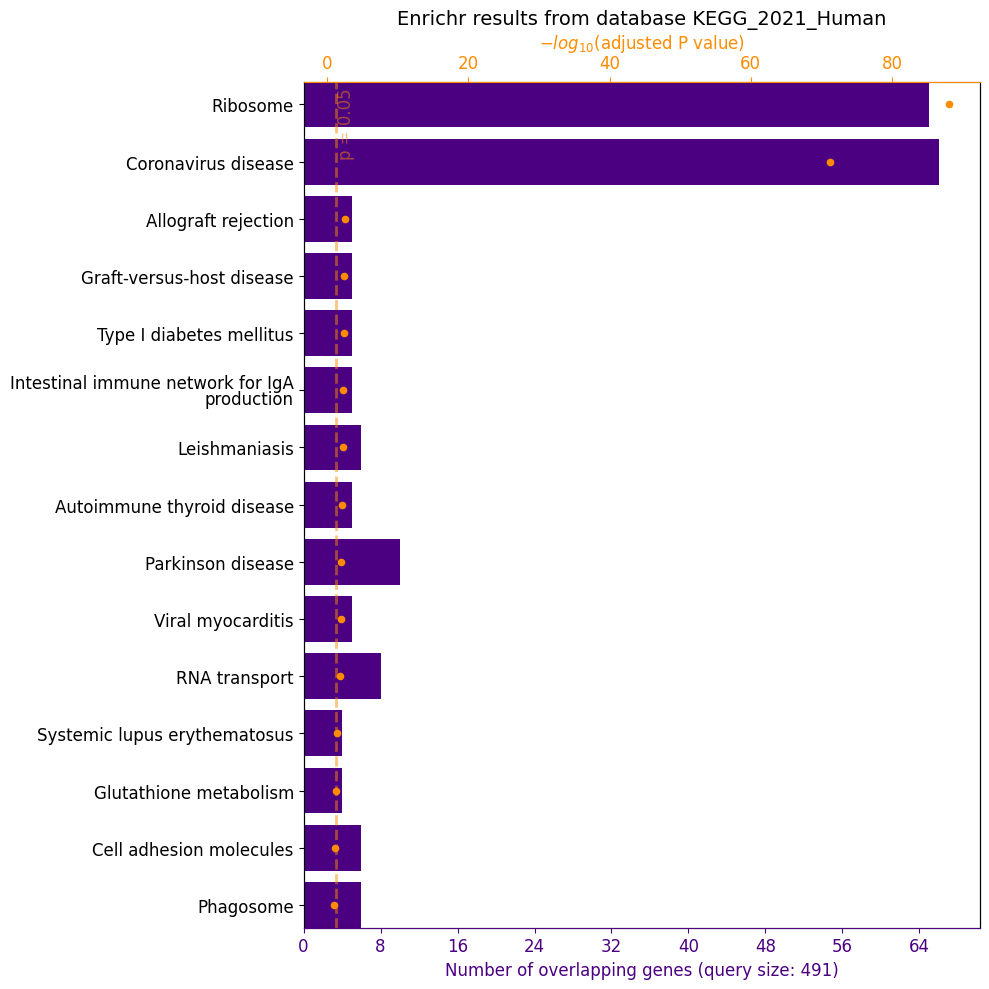

In [16]:
for database in databases:
    if database == "pathway" or database.startswith("KEGG"):
        kegg_out_path = f"{out_dir}/kegg_{database}.png"
    else:
        kegg_out_path = None
    try:
        gget.enrichr(top_mutant_gene_list, database, background_list = background_gene_list, plot = True, kegg_out = kegg_out_path, save = True)
        destination_path = f"{out_dir}/{database}.png"
        destination_dir = os.path.dirname(destination_path)
        # os.makedirs(destination_dir, exist_ok=True)
        shutil.move("./gget_enrichr_results.png", destination_path)
        csv_destination_path = destination_path.replace(".png", ".csv")
        shutil.move("./gget_enrichr_results.csv", csv_destination_path)
    except Exception as e:
        print(f"Error with {database}: {e}")
